In [ ]:
#Halloween begins frenetic candy consumption that continues into the Christmas holidays and New Year’s Day,
#when people often make (usually short-lived) resolutions to lose weight. But all this consumption first needs 
#production.The industrial production (IP) index measures the real output of all relevant establishments located 
#in the United States, regardless of their ownership. This dataset tracks industrial production every month from
#January 1972 to August 2017.

In [34]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox, kurtosis, skew
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,acf,pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
from pmdarima import auto_arima
from itertools import product
import seaborn as sns

In [36]:
df = pd.read_csv('candy_production.csv')
df.head()

,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


In [37]:
#rename columns/transform to datetime/set date columns as index
df = df.rename(columns={'observation_date': 'date', 'IPG3113N':'quantity'})
df['date']=pd.to_datetime(df['date'])
df.index = df.date
df = df.drop(columns=['date'])
df.head()

,quantity
date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [38]:
#check if there are any null values
df.isnull().sum()

quantity    0
dtype: int64

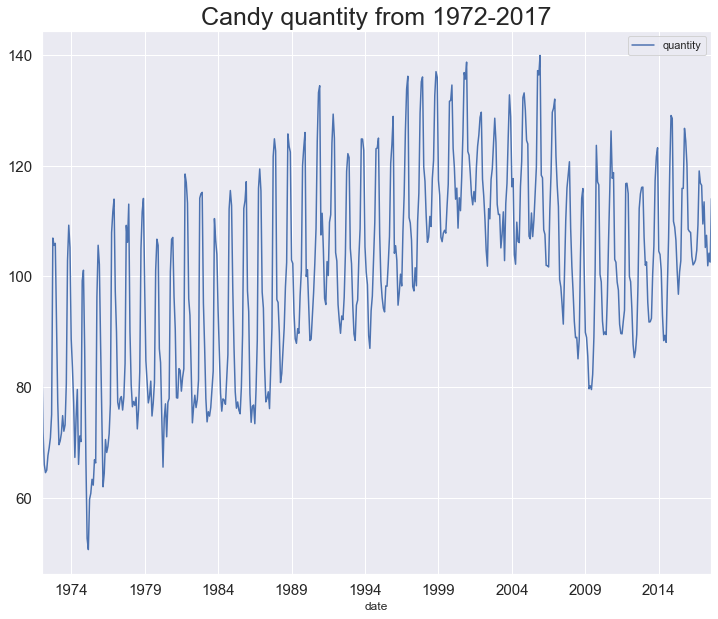

In [39]:
#plot candy production quantity
df.plot(figsize=(12, 10), fontsize=15)
plt.title('Candy quantity from 1972-2017', fontsize=25)
plt.show()

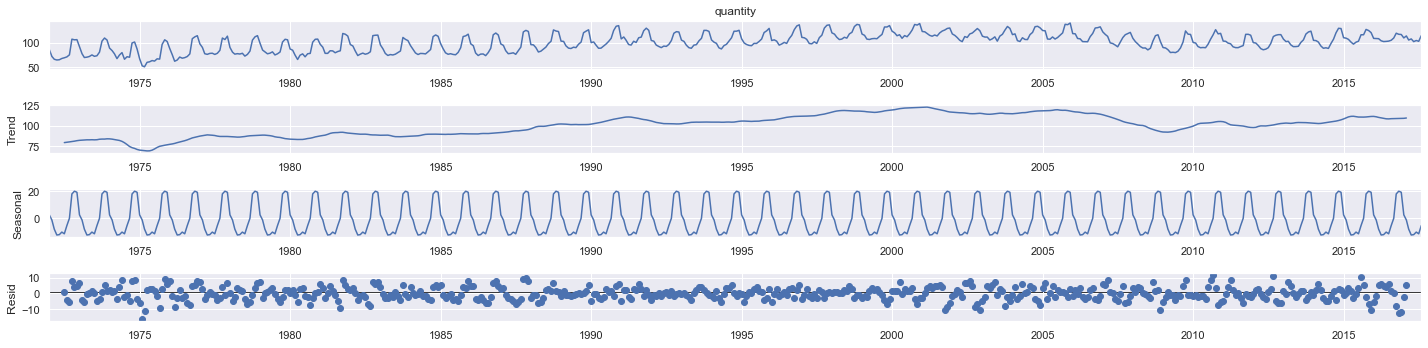

In [40]:
#decompose timeseries
sns.set(rc={'figure.figsize': (20,5)})
seasonal_decomp = seasonal_decompose(df['quantity'], model="additive")
seasonal_decomp.plot();
#the residual is hovering around zero/there is a trend/there is seasonality/
#seasonality for every year so seasonal periodocity m=12

<AxesSubplot:xlabel='date'>

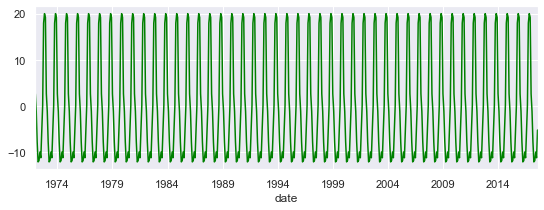

In [41]:
#plot the seasonal component
seasonality=seasonal_decomp.seasonal
seasonality.plot(color='green',figsize=(9,3))

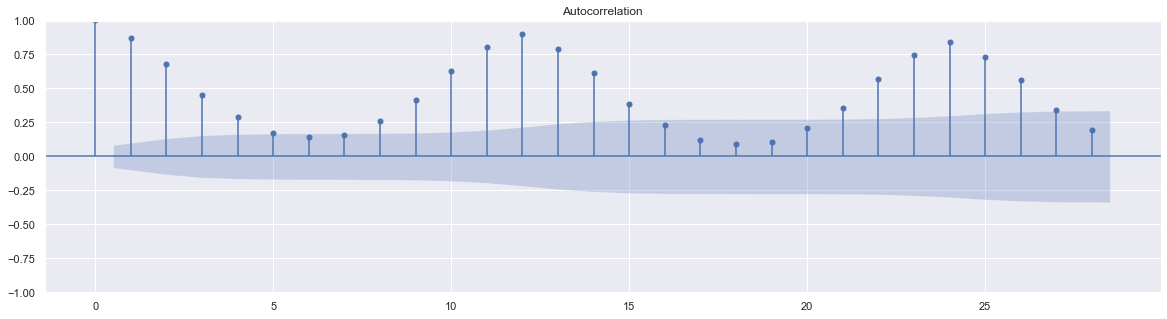

In [42]:
#From the above graphs we can see that there is surely a seasonal component in the data, 
#but to find out how many period we will plot an ACF plot
plot_acf(df);
#from the ACF plot we can clearly see that there is a repetation at every 12 months

In [43]:
def test_stationarity(timeseries):
    timeseries.dropna(inplace=True)
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    orig=plt.plot(timeseries,label='Original')
    mean=plt.plot(rolmean,label='Rolling mean')
    std=plt.plot(rolstd,label='Rolling std')
    
    plt.legend(loc='best')
    plt.title('Timeseries data with rolling mean and std')
    plt.show()
    
    dftest=adfuller(timeseries)
    dfoutput=pd.Series(dftest[0:3],index=['Test statistics','p-value','usedLags'])
    print(dfoutput)

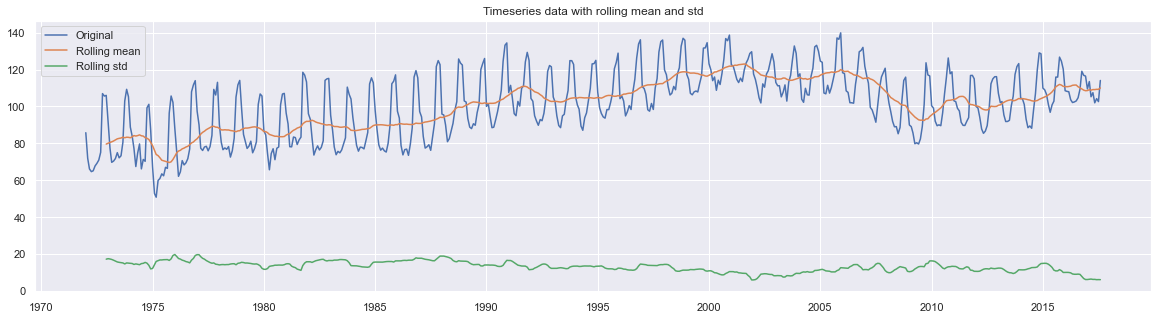

Test statistics    -1.887050
p-value             0.338178
usedLags           14.000000
dtype: float64


In [44]:
test_stationarity(df)
#has a trend part and a very proeminent seasonal part
#rolling mean has a variation of around 40
#rolling std is almost constant
#p-value > 0.05 so is not stationary

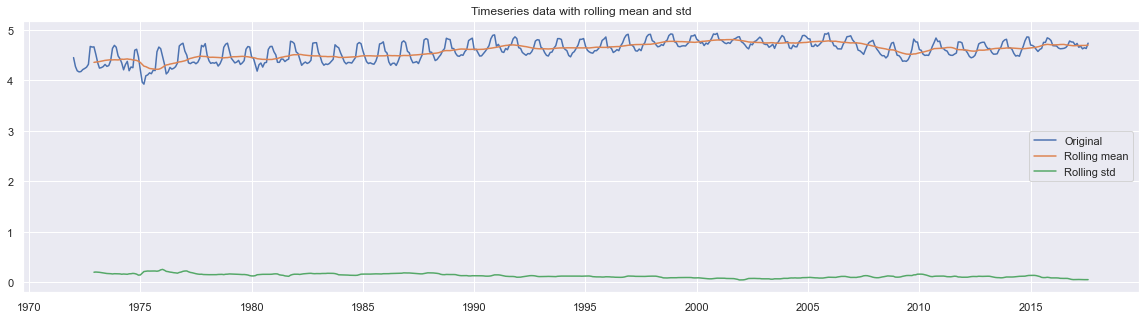

Test statistics    -1.841721
p-value             0.359954
usedLags           15.000000
dtype: float64


In [45]:
#transform data to make it stationary
df_log=np.log(df)
test_stationarity(df_log)
#rolling mean variance is very less now but it has a very proeminent seasonal component so is not stationary
#log hasn't remove the seasonal part

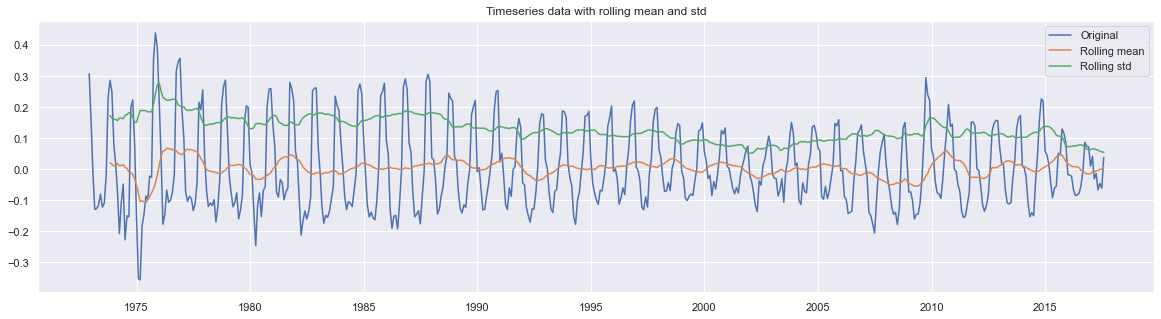

Test statistics   -7.573451e+00
p-value            2.801611e-11
usedLags           1.400000e+01
dtype: float64


In [46]:
#try to make it stationary by subtracting the yearly rolling average
ma=df_log.rolling(window=12).mean()
df_log_subtract_ma=df_log-ma
test_stationarity(df_log_subtract_ma)
#rolling mean is contant nearing zero/ rolling std is constant/but the data is having a character of seasonality
#because the p_value is less tha 0.05 let's assume the data is stationary and do the statistical model fitting and prediction and see how accurate is it

In [47]:
#try to make data stationary using Box-Cox Transformations
df['boxcox_quantity'], lmbda = boxcox(df.quantity)
print("Dickey–Fuller test: p=%f" % adfuller(df.quantity)[1])
print(f'Lambda Value {lmbda}')
#p-value > 0.05 so is not stationary

Dickey–Fuller test: p=0.338178
Lambda Value 1.2550906935610247


In [48]:
#seasonal differentiation
df['boxcox_quantity_diff'] = df.boxcox_quantity - df.boxcox_quantity.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(df.boxcox_quantity_diff[12:])[1])
#stationary because p-value<0.05

Dickey–Fuller test: p=0.000031


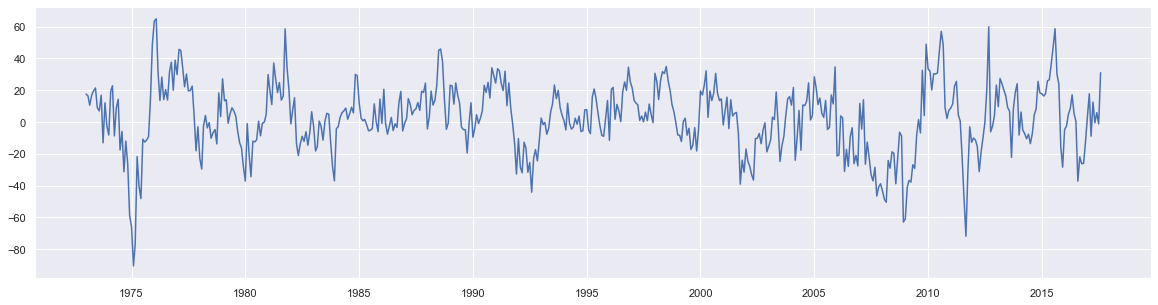

In [49]:
plt.plot(df['boxcox_quantity_diff'])

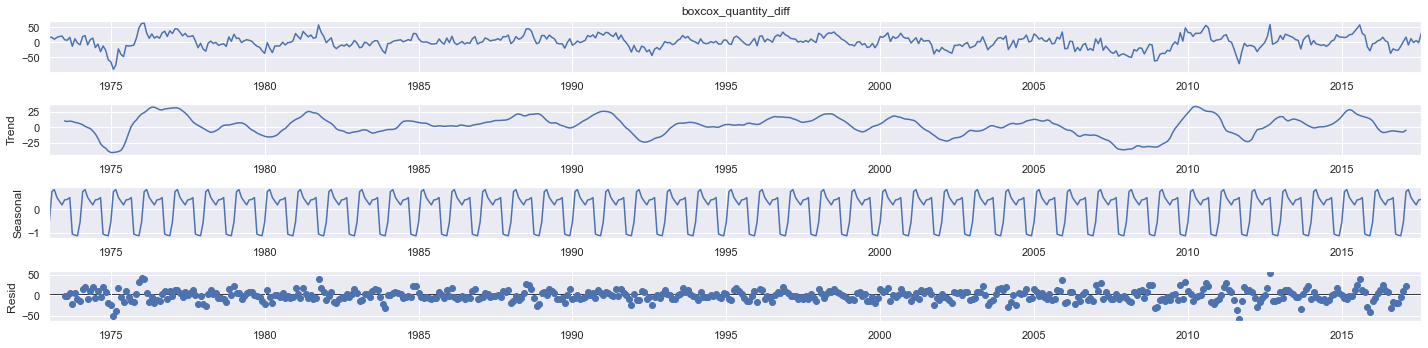

In [50]:
# STL-decomposition
seasonal_decompose(df.boxcox_quantity_diff[12:]).plot();
##there is still sesonality but because the p_value is less tha 0.05 we can assume the data is stationary and do the statistical model
#fitting and prediction and see how accurate is it

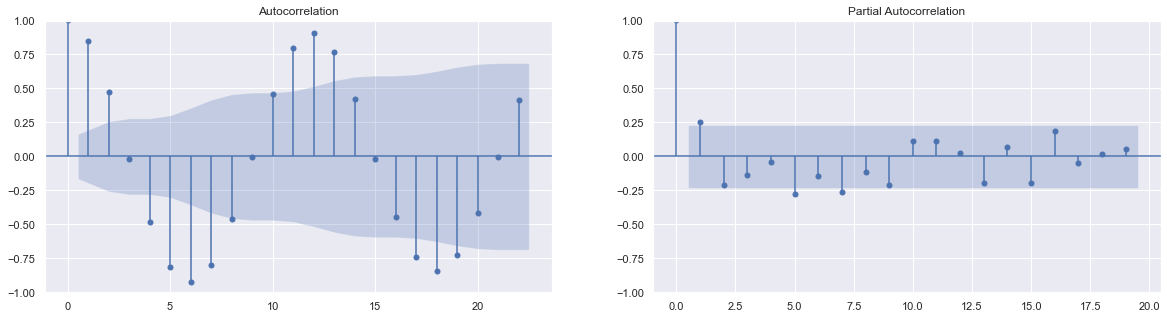

In [51]:
#will choose to use the log dataframe
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
lag_acf=acf(df_log_subtract_ma.quantity,nlags=140)
lag_pacf=pacf(df_log_subtract_ma.quantity,nlags=70)
fig,ax=plt.subplots(1,2,figsize=(20,5))
plot_acf(lag_acf,ax=ax[0])
plot_pacf(lag_pacf,ax=ax[1])
plt.show()

In [52]:
# Initial approximation of parameters
Qs = range(0, 4)
qs = range(0, 4)
Ps = range(0, 4)
ps = range(0, 4)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=SARIMAX(df_log_subtract_ma.quantity, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [53]:
# Best 5 models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

       parameters          aic
241  (3, 3, 0, 1) -1966.484132
249  (3, 3, 2, 1) -1951.520779
243  (3, 3, 0, 3) -1938.097286
245  (3, 3, 1, 1) -1937.966373
162  (2, 2, 0, 2) -1936.960212
                                      SARIMAX Results                                       
Dep. Variable:                             quantity   No. Observations:                  537
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 12)   Log Likelihood                 991.242
Date:                              Fri, 26 May 2023   AIC                          -1966.484
Time:                                      11:11:09   BIC                          -1932.392
Sample:                                  12-01-1972   HQIC                         -1953.133
                                       - 08-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025    

Dickey–Fuller test:: p=0.000000


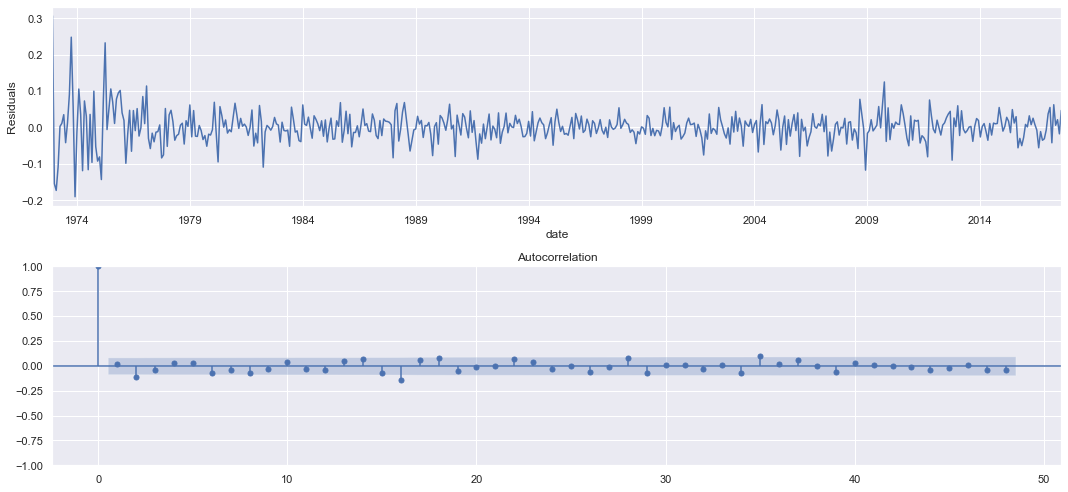

<AxesSubplot:ylabel='Density'>

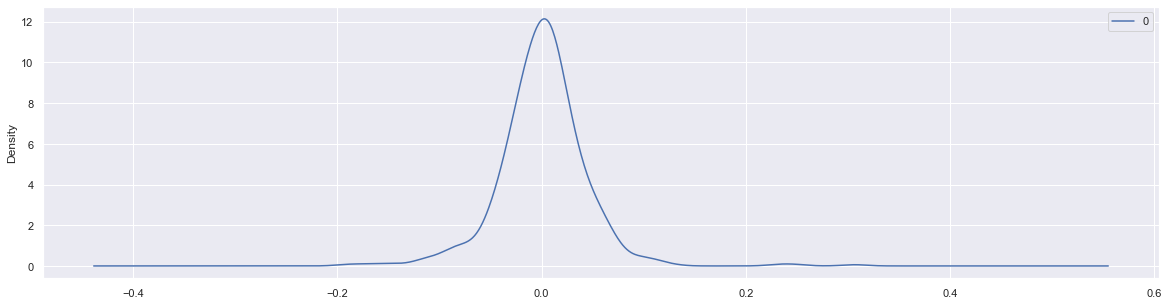

In [54]:
#analysis of residuals
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid)[1])

plt.tight_layout()
plt.show()
residual=pd.DataFrame(best_model.resid)
residual.plot(kind='kde')
#residuals are independent,hover around zero and normally distributed

In [55]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [56]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_log_subtract_ma,test_size=0.1,shuffle=False)

In [57]:
#best model fitting
model_sarimax=SARIMAX(train,order=(3,1,3),seasonal_order=(3,1,3,12))
model_sarimax_fit=model_sarimax.fit()
predictions=model_sarimax_fit.predict(start='2013-03-01',end='2017-08-01')

In [58]:
#model performance
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,predictions)
print(f'MSE={error}')

MSE=0.001985948390403911


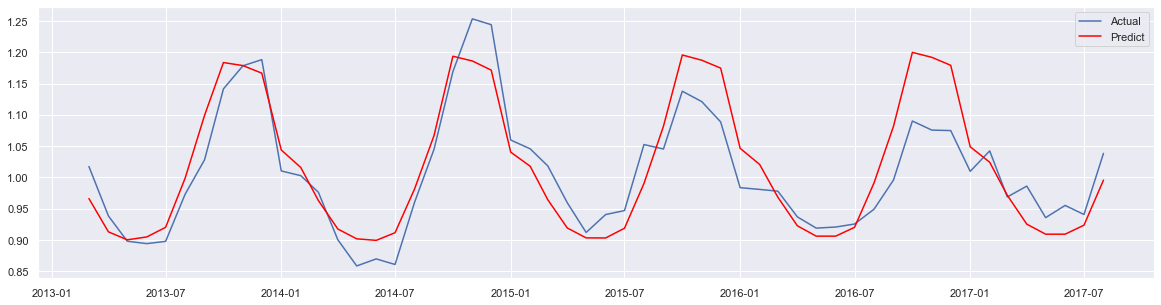

In [59]:
#actual vs prediction
predict=np.exp(predictions)
test_set=np.exp(test)
plt.plot(test_set,label='Actual')
plt.plot(predict,color='red',label='Predict')
plt.legend(loc='best')
plt.show()

In [60]:
#we will use auto_arima from pmdarima to get the optimal parameter of SARIMAX
auto_arima(df_log_subtract_ma.quantity,seasonal=True,m=12,suppress_warnings=True,information_criterion='aic',max_P=3,max_D=3,max_Q=3,max_p=3,max_d=3,max_q=3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  537
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 997.719
Date:                            Fri, 26 May 2023   AIC                          -1983.438
Time:                                    11:18:09   BIC                          -1957.722
Sample:                                12-01-1972   HQIC                         -1973.378
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6864      0.024     70.356      0.000       1.639       1.733
ar.L2         -0.7062      0.021    -33.505      0.000      -0.748      -0.665
ma.L1         -0.9860      0.013    -73.198      0.000      -1.012      -0.960
ar.S.L12       0.9910      0.003    360.961      0.000       0.986       0.996
ma.S.L12      -0.7004      0.034    -20.438      0.000      -0.768      -0.633
sigma2         0.0014   6.69e-05     20.276      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                64.01
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
#model fitting with auto-arima estimated best params
model_sarimax_auto=SARIMAX(train,order=(2,0,1),seasonal_order=(1,0,1,12))
model_sarimax_fit_auto=model_sarimax_auto.fit()
predictions_auto=model_sarimax_fit_auto.predict(start='2013-03-01',end='2017-08-01')

In [62]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,predictions)
print(f'MSE={error}')

MSE=0.001985948390403911


Dickey–Fuller test:: p=0.000000


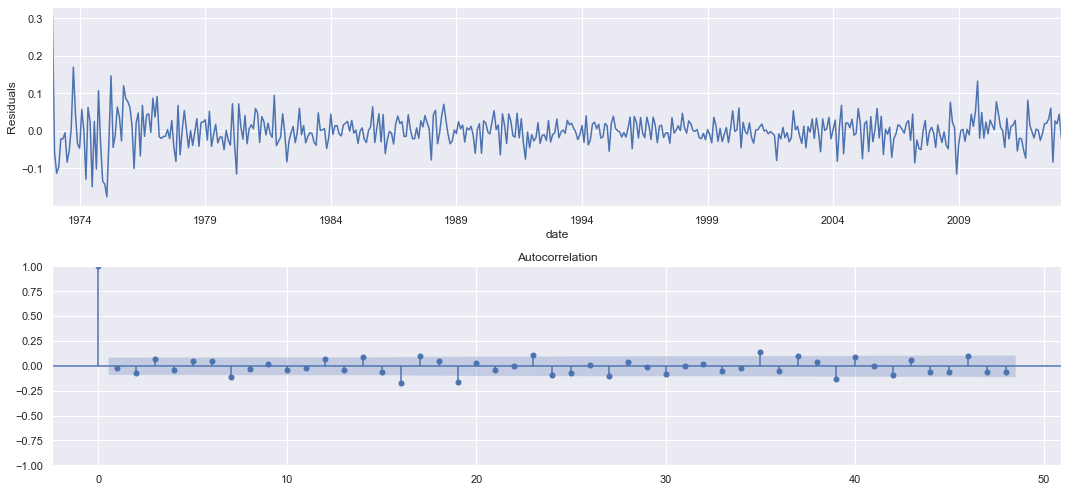

<AxesSubplot:ylabel='Density'>

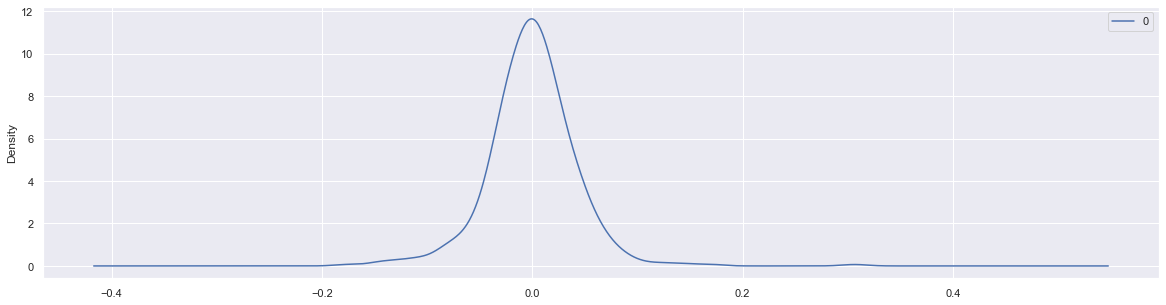

In [63]:
#analysis of residuals
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
model_sarimax_fit_auto.resid.plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
plot_acf(model_sarimax_fit_auto.resid.values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(model_sarimax_fit_auto.resid)[1])

plt.tight_layout()
plt.show()
residual=pd.DataFrame(model_sarimax_fit_auto.resid)
residual.plot(kind='kde')
#residuals are independent,hover around zero and normally distributed

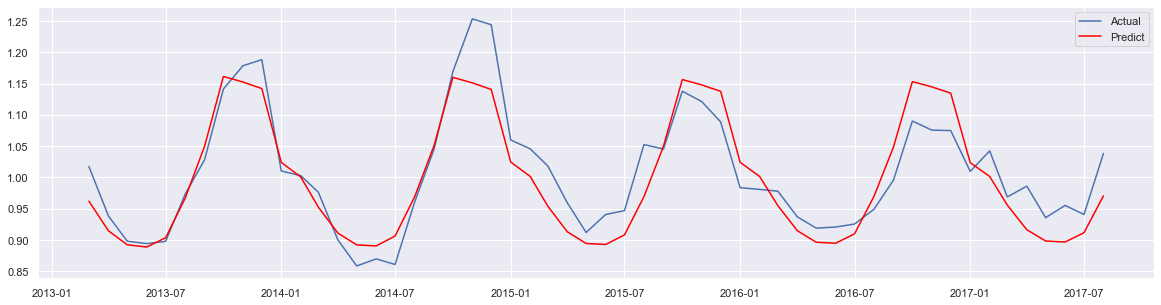

In [64]:
predict_auto=np.exp(predictions_auto)
test_set_auto=np.exp(test)
plt.plot(test_set_auto,label='Actual')
plt.plot(predict_auto,color='red',label='Predict')
plt.legend(loc='best')
plt.show()

In [65]:
#Now we will train our model on whole data for Forecasting
model_forecast = SARIMAX(df_log_subtract_ma,order=(2,0,1),seasonal_order=(1,0,1,12))
model_forecast_fit = model_forecast.fit()
pred_forecast = model_forecast_fit.predict(len(df_log_subtract_ma)-1,len(df_log_subtract_ma)+48,type='levels')

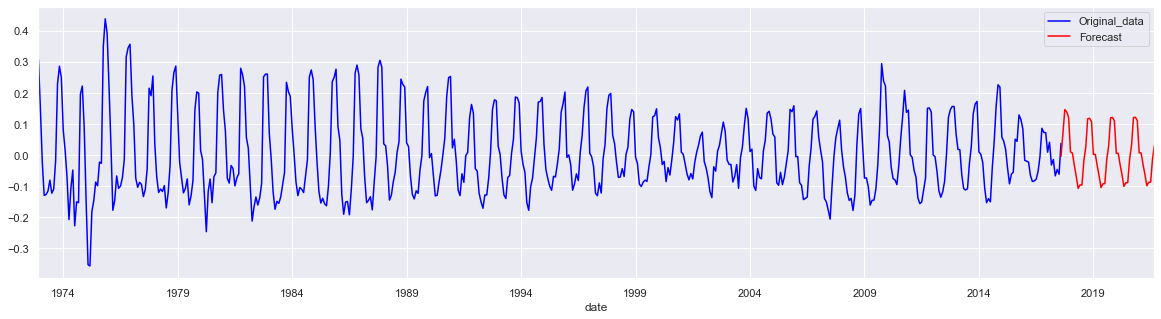

In [66]:
#candy quantity forecasting
fig, ax = plt.subplots()
ax=df_log_subtract_ma.plot(color='blue',ax=ax)
ax=pred_forecast.plot(color='red',ax=ax)
ax.legend(['Original_data','Forecast'])